# Импорт необходимых библиотек

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from autogluon.tabular import TabularPredictor
from prophet import Prophet
from torch.utils.data import DataLoader, TensorDataset
import warnings 
warnings.filterwarnings("ignore")

# Данные демографии и магазина

In [2]:
demographic = pd.read_parquet('data/demographic_data.parquet')

In [3]:
demographic

,store,age60,age9,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
1,2.0,0.232865,0.117509,0.248935,0.114280,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.927280,0.376927
2,4.0,0.262030,0.095090,0.220789,0.062161,10.646972,0.088123,0.362122,0.522236,2.373200,1.000000,1.104470,0.772489
3,5.0,0.117368,0.141433,0.321226,0.053875,10.922371,0.103092,0.410568,0.535883,3.801998,0.681818,1.600573,0.736307
4,8.0,0.252394,0.123155,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
5,9.0,0.269119,0.103503,0.222172,0.032619,10.787151,0.096830,0.358995,0.505747,1.103279,0.666667,1.820474,0.441268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,308.0,0.235498,0.120519,0.159787,0.185974,10.439542,0.113268,0.316430,0.290223,NaN,NaN,NaN,NaN
104,309.0,0.067192,0.200156,0.278103,0.204785,10.757754,0.152418,0.392109,0.406664,NaN,NaN,NaN,NaN
105,310.0,0.177015,0.134641,0.283289,0.045067,10.861496,0.100310,0.421429,0.594775,NaN,NaN,NaN,NaN
106,312.0,0.161864,0.151115,0.122721,0.195317,10.500509,0.139724,0.309058,0.096444,NaN,NaN,NaN,NaN


# Beer

In [4]:
beer_sales = pd.read_parquet('data/beer_sales_data.parquet')
beer_upc = pd.read_parquet('data/beer_upc.parquet')

### Обьединение данных

In [5]:
beer_data = pd.merge(beer_sales, beer_upc, on='upc', how='left')
beer = beer_data.merge(demographic, on='store', how='left')

### Просмотр данных

In [6]:
beer.head(7)

,store,upc,week,move,qty,price,sale,com_code,descrip,size,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
0,2,294,298,11,1,2.62,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
1,2,294,299,9,1,2.51,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
2,2,294,300,6,1,2.49,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
3,2,294,301,5,1,2.99,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
4,2,294,302,1,1,2.49,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
5,2,294,303,0,1,0.00,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927
6,2,294,304,1,1,4.99,None,27,BEER LIMIT,12/12O,...,0.248935,0.11428,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.92728,0.376927


In [7]:
beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3967720 entries, 0 to 3967719
Data columns (total 24 columns):
 #   Column    Dtype  
---  ------    -----  
 0   store     int64  
 1   upc       int64  
 2   week      int64  
 3   move      int64  
 4   qty       int64  
 5   price     float64
 6   sale      object 
 7   com_code  int64  
 8   descrip   object 
 9   size      object 
 10  case      int64  
 11  nitem     int64  
 12  age60     float32
 13  age9      float32
 14  educ      float32
 15  ethnic    float32
 16  income    float32
 17  hhlarge   float32
 18  workwom   float32
 19  hval150   float32
 20  sstrdist  float32
 21  sstrvol   float32
 22  cpdist5   float32
 23  cpwvol5   float32
dtypes: float32(12), float64(1), int64(8), object(3)
memory usage: 544.9+ MB


In [8]:
beer.describe()

,store,upc,week,move,qty,price,com_code,case,nitem,age60,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
count,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.967720e+06,3.738649e+06,...,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06,3.738649e+06
mean,8.881704e+01,7.234429e+09,2.364477e+02,3.383864e+00,1.000011e+00,2.819041e+00,2.689510e+01,3.844397e+00,9.096410e+06,1.737367e-01,...,2.203140e-01,1.484588e-01,1.061433e+01,1.177069e-01,3.563791e-01,3.393292e-01,5.037027e+00,1.167110e+00,2.136872e+00,4.249844e-01
std,3.635469e+01,1.072429e+10,8.410145e+01,8.877261e+00,3.330071e-03,3.422010e+00,5.119450e-01,2.797815e+00,9.454292e+06,6.534513e-02,...,1.109482e-01,1.789707e-01,3.010606e-01,3.236447e-02,5.104252e-02,2.413650e-01,3.373427e+00,5.197779e-01,7.296672e-01,2.041200e-01
min,2.000000e+00,2.940000e+02,9.100000e+01,0.000000e+00,1.000000e+00,0.000000e+00,2.600000e+01,1.000000e+00,-2.684392e+08,5.805397e-02,...,4.955029e-02,2.424657e-02,9.867083e+00,1.350636e-02,2.444627e-01,2.509410e-03,1.320968e-01,4.000000e-01,7.725297e-01,9.456175e-02
25%,7.000000e+01,3.410016e+09,1.670000e+02,0.000000e+00,1.000000e+00,0.000000e+00,2.700000e+01,2.000000e+00,9.406600e+06,1.173680e-01,...,1.443101e-01,4.154243e-02,1.041439e+01,9.683047e-02,3.115727e-01,9.996325e-02,2.636333e+00,7.058824e-01,1.626192e+00,2.716730e-01
50%,9.700000e+01,7.199012e+09,2.360000e+02,0.000000e+00,1.000000e+00,0.000000e+00,2.700000e+01,4.000000e+00,9.412050e+06,1.706548e-01,...,2.195484e-01,7.396162e-02,1.064766e+01,1.136868e-01,3.589945e-01,3.461539e-01,4.235049e+00,1.090909e+00,2.007204e+00,3.832268e-01
75%,1.180000e+02,7.336078e+09,3.020000e+02,3.000000e+00,1.000000e+00,4.990000e+00,2.700000e+01,4.000000e+00,9.450300e+06,2.225343e-01,...,2.799520e-01,1.877609e-01,1.079696e+01,1.353408e-01,3.982512e-01,5.339496e-01,6.678130e+00,1.500000e+00,2.656879e+00,5.543523e-01
max,1.460000e+02,7.970964e+10,3.990000e+02,7.690000e+02,2.000000e+00,2.964000e+01,2.800000e+01,2.400000e+01,9.990180e+06,3.073978e-01,...,5.283620e-01,9.956908e-01,1.123620e+01,2.163543e-01,4.723083e-01,9.166995e-01,1.785595e+01,2.571429e+00,4.107902e+00,1.143367e+00


### Поиск пропущенных значений

In [9]:
def percent_missing(df):
    total = 100 *df.isnull().sum() / len(df)
    total = total[total > 0].sort_values(ascending=False)
    return total

In [10]:
beer_missing = percent_missing(beer)
beer_missing

sale        86.202756
age60        5.773366
age9         5.773366
educ         5.773366
ethnic       5.773366
income       5.773366
hhlarge      5.773366
workwom      5.773366
hval150      5.773366
sstrdist     5.773366
sstrvol      5.773366
cpdist5      5.773366
cpwvol5      5.773366
dtype: float64

### Обработка пропущенных значений

In [11]:
beer['sale'] = beer['sale'].fillna('Unknown')

In [12]:
col = ['age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge', 'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5']

In [13]:
for column in col:
    beer[column] = beer[column].fillna(beer[column].median())

In [14]:
beer_missing = percent_missing(beer)
beer_missing

Series([], dtype: float64)

### Преобразуем week в datetime

In [15]:
def week_to_date(week):
     week = int(week)
     start = pd.to_datetime('1989-09-14') # - данные с манула
     days_add = (week - 1) * 7 
     return start+ pd.Timedelta(days=days_add)

In [16]:
beer['date'] = beer['week'].apply(week_to_date)

In [17]:
beer['date']

0         1995-05-25
1         1995-06-01
2         1995-06-08
3         1995-06-15
4         1995-06-22
             ...    
3967715   1997-04-03
3967716   1997-04-10
3967717   1997-04-17
3967718   1997-04-24
3967719   1997-05-01
Name: date, Length: 3967720, dtype: datetime64[ns]

### Визуализация

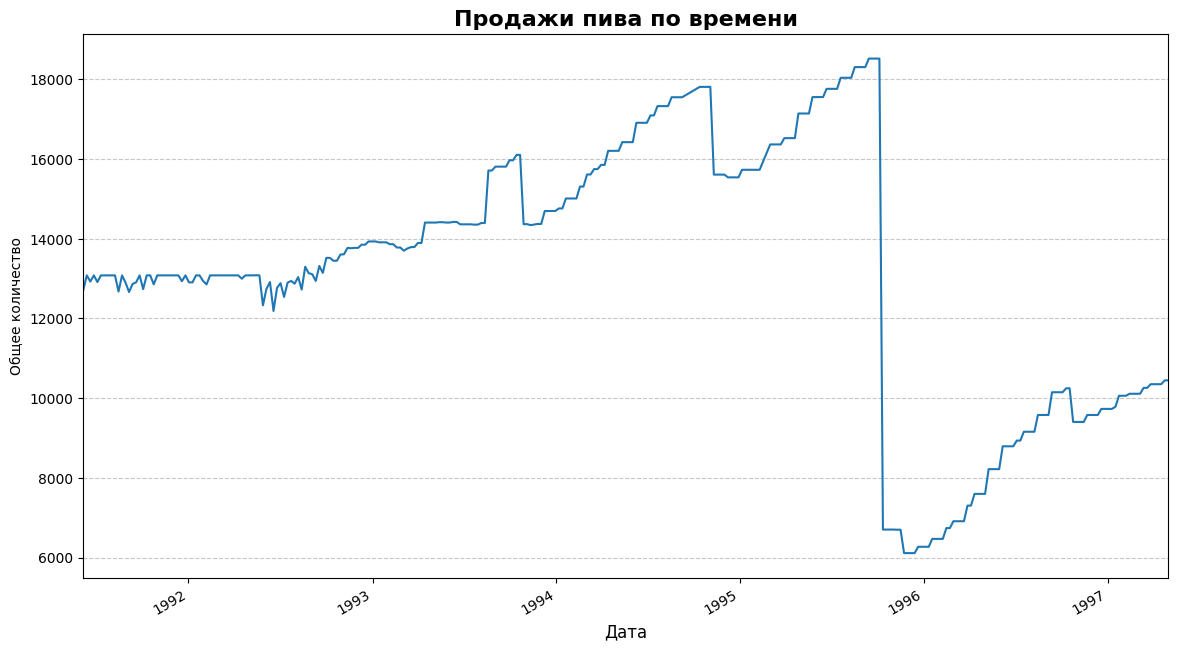

In [18]:
plt.figure(figsize=(14, 8))
beer.groupby('date')['qty'].sum().plot()
plt.title('Продажи пива по времени', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Общее количество')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(x=0)
plt.show()

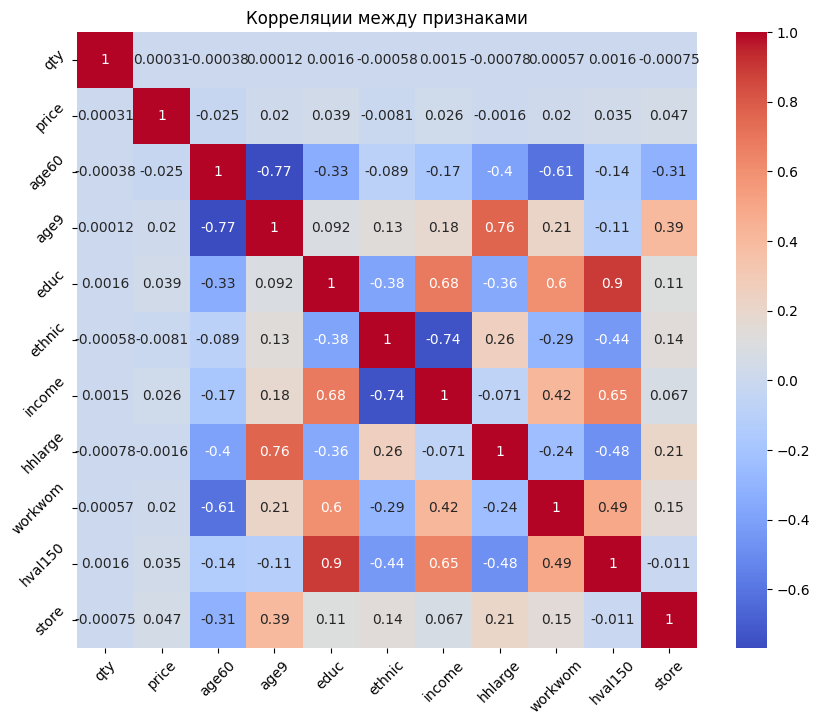

In [19]:
corr = beer[['qty', 'price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge', 'workwom', 'hval150','store']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляции между признаками')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Нахождение выбросов

In [20]:
high_corr = ['hval150', 'educ', 'income']

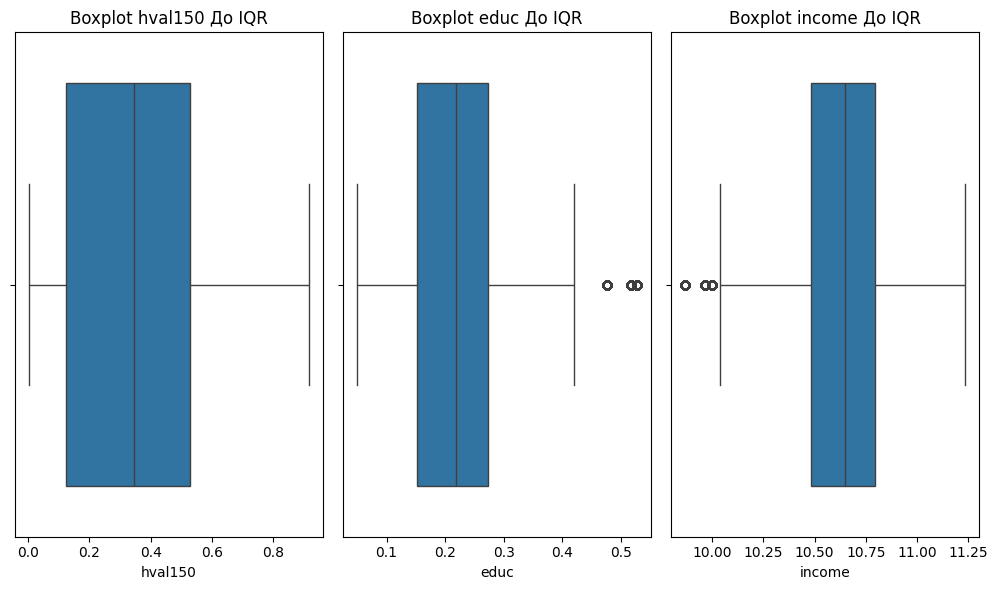

In [21]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(high_corr, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=beer[col])
    plt.title(f'Boxplot {col} До IQR')
plt.tight_layout()
plt.show()

### Удаление выбросов

In [22]:
def iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [23]:
for col in high_corr:
    lower_bound, upper_bound = iqr(beer, col)
    beer = beer[(beer[col] >= lower_bound) & (beer[col] <= upper_bound)]

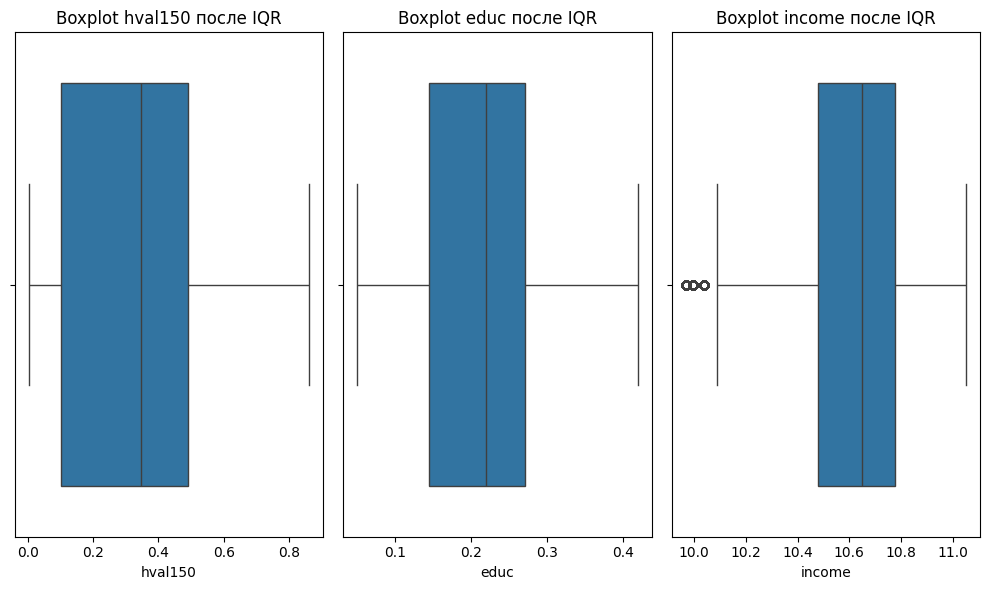

In [24]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(high_corr, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=beer[col])
    plt.title(f'Boxplot {col} после IQR')
plt.tight_layout()
plt.show()

### Feature Engineering

In [25]:
beer_agg = beer.groupby('date').agg(
    {'qty': 'sum', 
    'price': 'mean'}
).reset_index()

In [26]:
beer_agg['dayofweek'] = beer_agg['date'].dt.dayofweek
beer_agg['month'] = beer_agg['date'].dt.month
beer_agg['year'] = beer_agg['date'].dt.year

In [27]:
beer_agg['qty_lag1'] = beer_agg['qty'].shift(1)
beer_agg['qty_lag2'] = beer_agg['qty'].shift(2)
beer_agg['qty_lag3'] = beer_agg['qty'].shift(3)

In [28]:
beer_agg = beer_agg.dropna()

In [29]:
beer_agg

,date,qty,price,dayofweek,month,year,qty_lag1,qty_lag2,qty_lag3
3,1991-06-27,12491,2.696686,3,6,1991,12336.0,12491.0,12324.0
4,1991-07-04,12324,2.862903,3,7,1991,12491.0,12336.0,12491.0
5,1991-07-11,12490,2.898503,3,7,1991,12324.0,12491.0,12336.0
6,1991-07-18,12491,2.842217,3,7,1991,12490.0,12324.0,12491.0
7,1991-07-25,12491,2.809736,3,7,1991,12491.0,12490.0,12324.0
...,...,...,...,...,...,...,...,...,...
297,1997-04-03,9748,2.525256,3,4,1997,9748.0,9661.0,9661.0
298,1997-04-10,9748,2.303949,3,4,1997,9748.0,9748.0,9661.0
299,1997-04-17,9748,2.497338,3,4,1997,9748.0,9748.0,9748.0
300,1997-04-24,9836,2.474511,3,4,1997,9748.0,9748.0,9748.0


### Анализ эластичности

In [30]:
elastic = beer_agg.groupby('price')['qty'].mean().reset_index()

In [31]:
elastic['price_change'] = elastic['price'].pct_change()
elastic['qty_change'] = elastic['qty'].pct_change()

In [32]:
# изменение qty / изменение цены
elastic['elasticity'] = elastic['qty_change'] / elastic['price_change']

In [33]:
elastic = elastic.dropna()

In [34]:
# Сглаживание эластичности с помощью скользящего среднего
elastic['elasticity_smoothed'] = elastic['elasticity'].rolling(window=5,center=True).mean()

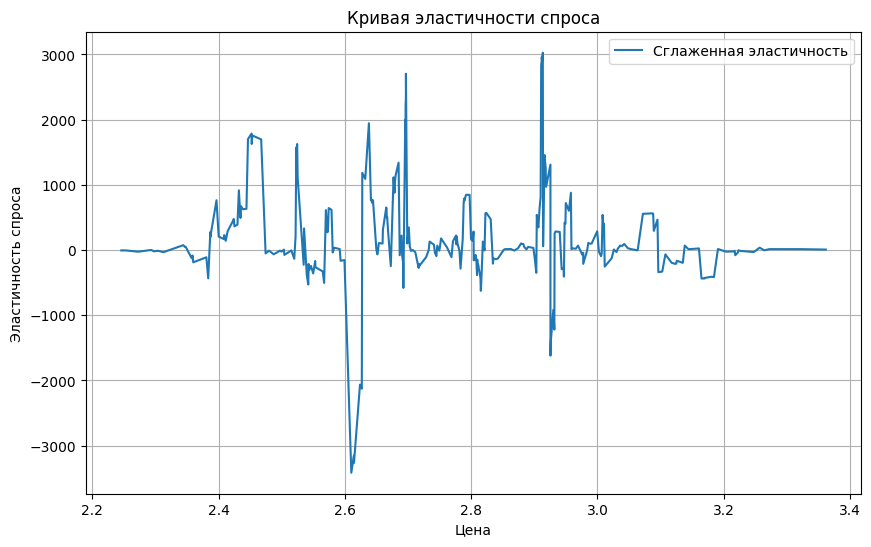

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(elastic['price'], elastic['elasticity_smoothed'], label='Сглаженная эластичность')
plt.xlabel('Цена')
plt.ylabel('Эластичность спроса')
plt.title('Кривая эластичности спроса')
plt.grid(True)
plt.legend()
plt.show()

### Подготовка к обучению

In [36]:
X = beer_agg.drop(['date', 'qty'], axis=1)
y = beer_agg['qty']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
scaler = StandardScaler()

In [39]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Модель (XGBoost)

#### Подбор параметров XGBoost

In [40]:
xg_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# - пока поставил базовые гиперпараметры.
# - но можно использовать gridsearchcv, для поиска лучших гиперпараметров.

#### Обучение модели XGBoost

In [41]:
xg_model.fit(X_train, y_train)
xg_pred = xg_model.predict(X_test)

#### Результаты модели XGBoost

In [42]:
xg_mae = mean_absolute_error(y_test, xg_pred)
xg_rmse = np.sqrt(mean_squared_error(y_test, xg_pred))
xg_r2 = r2_score(y_test, xg_pred)

In [43]:
print(f'XGBoost R^2 {xg_r2:.4f}')
print(f'XGBoost MAE: {xg_mae:.4f}')
print(f'XGBoost RMSE: {xg_rmse:.4f}')

XGBoost R^2 0.9967
XGBoost MAE: 117.3602
XGBoost RMSE: 167.0654


### Модель(AutoGluon) 

#### Обучение модели AutoGluon

In [44]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [45]:
ag_predictor = TabularPredictor(label='qty', eval_metric='rmse', verbosity=0).fit(train_data)
ag_pred = ag_predictor.predict(X_test)

#### Результаты модели AutoGluon

In [46]:
leaderboard = ag_predictor.leaderboard(silent=True)
print(leaderboard)

                  model   score_val              eval_metric  pred_time_val  \
0   WeightedEnsemble_L2 -206.104550  root_mean_squared_error       0.003034   
1        NeuralNetTorch -206.104550  root_mean_squared_error       0.003034   
2        KNeighborsDist -389.216481  root_mean_squared_error       0.008421   
3        KNeighborsUnif -393.685297  root_mean_squared_error       0.068525   
4       NeuralNetFastAI -479.320693  root_mean_squared_error       0.008000   
5            LightGBMXT -509.788418  root_mean_squared_error       0.002998   
6         ExtraTreesMSE -572.614050  root_mean_squared_error       0.035000   
7              LightGBM -607.931466  root_mean_squared_error       0.003001   
8       RandomForestMSE -663.220266  root_mean_squared_error       0.034864   
9               XGBoost -816.297230  root_mean_squared_error       0.003003   
10             CatBoost -846.472940  root_mean_squared_error       0.000997   
11        LightGBMLarge -954.373533  root_mean_squar

In [47]:
ag_mae = mean_absolute_error(y_test, ag_pred)
ag_rmse = np.sqrt(mean_squared_error(y_test, ag_pred))
ag_r2 = r2_score(y_test, ag_pred)

In [48]:
print(f'AutoGluon R^2: {ag_r2:.4f}')
print(f'AutoGluon MAE: {ag_mae:.4f}')
print(f'AutoGluon RMSE: {ag_rmse:.4f}')

AutoGluon R^2: 0.9958
AutoGluon MAE: 133.1277
AutoGluon RMSE: 187.5365


### Модель (LSTNet) 

#### Подготовка к обучеию LSTNet

In [49]:
def prepare_lstnet_data(data, sequence_length, num_features):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)

#### Создание класса LSTNet

In [50]:
class LSTNetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_length, num_features):
        super(LSTNetModel, self).__init__()
        self.input_size = input_size
        self.num_features = num_features
        self.conv1 = nn.Conv1d(
            in_channels=num_features,
            out_channels=hidden_size,
            kernel_size=3,
            padding=1
        )
        
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        conv_out = self.conv1(x)
        conv_out = conv_out.transpose(1, 2)
        lstm_out, _ = self.lstm(conv_out)
        last_time_step = lstm_out[:, -1, :]
        output = self.fc(last_time_step)
        
        return output

#### Обучение и результаты LSTNet

In [51]:
def train_lstnet(beer_agg, sequence_length=10, hidden_size=64, learning_rate=0.001, epochs=100):
    features = ['qty', 'price', 'dayofweek', 'month', 'year', 'qty_lag1', 'qty_lag2']
    data = beer_agg[features].values
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = prepare_lstnet_data(data_scaled, sequence_length, len(features))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train)
    y_test_tensor = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = LSTNetModel(
        input_size=1,
        hidden_size=hidden_size,
        output_size=1,
        seq_length=sequence_length,
        num_features=len(features)
    )

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor)
        test_pred_np = test_pred.detach().numpy()
        y_test_np = y_test

        mae = mean_absolute_error(y_test_np, test_pred_np)
        rmse = np.sqrt(mean_squared_error(y_test_np, test_pred_np))
        r2 = r2_score(y_test_np, test_pred_np)

        print(f"LSTNet R^2: {r2:.4f}")
        print(f"LSTNet MAE: {mae:.4f}")
        print(f"LSTNet RMSE: {rmse:.4f}")
        
    return model, scaler, r2, mae, rmse

In [52]:
model, scaler, lstnet_r2, lstnet_mae, lstnet_rmse = train_lstnet(beer_agg)

Epoch [10/100], Loss: 0.0647
Epoch [20/100], Loss: 0.0589
Epoch [30/100], Loss: 0.0476
Epoch [40/100], Loss: 0.0449
Epoch [50/100], Loss: 0.0462
Epoch [60/100], Loss: 0.0418
Epoch [70/100], Loss: 0.0412
Epoch [80/100], Loss: 0.0472
Epoch [90/100], Loss: 0.0548
Epoch [100/100], Loss: 0.0384
LSTNet R^2: 0.9356
LSTNet MAE: 0.1063
LSTNet RMSE: 0.2668


### Сравнение моделей

In [53]:
results = pd.DataFrame({
    'Model': ['XGBoost', 'AutoGluon', 'LSTNet'],
    'R^2': [xg_r2, ag_r2, lstnet_r2],
    'MAE': [xg_mae, ag_mae, lstnet_mae],
    'RMSE': [xg_rmse, ag_rmse, lstnet_rmse]
})

In [54]:
results

,Model,R^2,MAE,RMSE
0,XGBoost,0.996688,117.360229,167.065378
1,AutoGluon,0.995826,133.127702,187.536530
2,LSTNet,0.935628,0.106285,0.266752
